# Temporal Analysis of  adoption of vulnerable versions of Rack pcackages in Ruby
https://www.cvedetails.com/cve/CVE-2015-3225/


In [30]:
%matplotlib inline
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("ticks")
sns.set_context("notebook")

## Load the dependency data

In [ ]:
data = pd.read_csv("../data/cleaned_Ruby_dependency_final.csv.gz")

In [3]:
data.query("project_name == 'rack'").head(5)

,project_github,project_name,project_ver,adopted_name,adopted_ver,scope,is_published,commit_ts,new_ver
8923187,rack,rack,0.9.0,camping,>= 0,NaN,1,1231196400,1.5.180
8923188,rack,rack,0.9.0,fcgi,>= 0,NaN,1,1231196400,0.8.7
8923189,rack,rack,0.9.0,memcache-client,>= 0,NaN,1,1231196400,1.5.0
8923190,rack,rack,0.9.0,mongrel,>= 0,NaN,1,1231196400,1.1.5
8923191,rack,rack,0.9.0,test-spec,>= 0,NaN,1,1231196400,0.9.0


In [4]:
releases = pd.read_csv("../data/cleaned_Ruby_release_final.csv.gz")

In [5]:
releases.query("project_name == 'rack'").head(5)

,project_github,project_name,project_ver,release_ts,is_published
514886,rack,rack,0.1.0,1172876400,1
514887,rack,rack,0.2.0,1179266400,1
514888,rack,rack,0.3.0,1203980400,1
514889,rack,rack,0.4.0,1219269600,1
514890,rack,rack,0.9.0,1231196400,1


## Construct network 

In [6]:
#Make composite key for easy network construction
data['src'] = data['project_github'] + ":::" + data['project_ver'].map(str)
data['trgt'] = data['adopted_name'] + ":::" + data['new_ver']

In [7]:
#we create a networks with reversed edges for easy traversal
g = nx.from_pandas_edgelist(data,  "trgt", "src",create_using=nx.DiGraph())


In [8]:
versions = ['0.1.0', '0.2.0', '0.3.0', '0.4.0', '0.9.0', '0.9.1', '1.0.0', '1.0.1',
       '1.1.0', '1.1.1', '1.1.1.pre', '1.1.2', '1.1.3', '1.1.4', '1.1.5',
       '1.1.6', '1.2.0', '1.2.1', '1.2.2', '1.2.3', '1.2.4', '1.2.5', '1.2.6',
       '1.2.7', '1.2.8', '1.3.0', '1.3.0.beta', '1.3.0.beta2', '1.3.1',
       '1.3.10', '1.3.2', '1.3.3', '1.3.4', '1.3.5', '1.3.6', '1.3.7', '1.3.8',
       '1.3.9', '1.4.0', '1.4.1', '1.4.2', '1.4.3', '1.4.4', '1.4.5', '1.4.6',
       '1.4.7', '1.5.0', '1.5.0.beta.1', '1.5.1', '1.5.2', '1.5.3', '1.5.4',
       '1.5.5', '1.6.0', '1.6.0.beta', '1.6.0.beta2', '1.6.1', '1.6.2',
       '1.6.3', '1.6.4', '2.0.0.alpha', '2.0.0.rc1', '2.0.1']
not_affected = ['1.5.4','1.5.5','1.6.2', '1.6.3', '1.6.4', '2.0.0.alpha', '2.0.0.rc1', '2.0.1']
affected = set(versions) - set(not_affected)

affected_nodes = ["rack:::" + x for x in affected]
not_affected_nodes = ["rack:::" + x for x in not_affected]


## Find all nodes connected to vulnrable and non-vulnrable releases

In [9]:
affected_reachable = {}
not_affected_reachable = {}

for x in affected_nodes:
    reachable = set(nx.dfs_preorder_nodes(g,x))
    affected_reachable[x] = reachable

for x in not_affected_nodes:
    reachable = set(nx.dfs_preorder_nodes(g,x))
    not_affected_reachable[x] = reachable
    

## Construct dataset with projects that adopted vulnrable versions

In [10]:
def mapping(reach, fixed_release=0):
    adopted = []
    for k, v in reach.items():
        key = k.split(":::")
        rows = map(lambda x:list(key) + list(x.split(":::")),v)
        adopted.extend(list(rows))
    df = pd.DataFrame.from_records(adopted, columns=["target_proj", "target_ver", "project_name", "project_ver"])
    df["vulnerable_target"] = fixed_release
    return  df

adoption_bad = mapping(affected_reachable, 1)
adoption_good  = mapping(not_affected_reachable, 0)

In [11]:
stacked = pd.concat([adoption_bad, adoption_good])

In [12]:
stacked_ts = pd.merge(stacked, releases[["project_name", "project_ver", "release_ts"]], on=["project_name", "project_ver"], how="left")
stacked_ts.release_ts = stacked_ts.release_ts.map(float)
stacked_ts.loc[pd.isnull(stacked_ts.release_ts), "release_ts"] = stacked_ts.loc[pd.isnull(stacked_ts.release_ts), "project_ver"].map(float)
stacked_ts.loc[:, "release_ts"] = pd.to_datetime(stacked_ts.loc[:, "release_ts"], unit='s')

In [13]:
fixes = stacked_ts[["project_name", "vulnerable_target", "release_ts"]].groupby(["project_name", "vulnerable_target"]).min().reset_index()

In [14]:
fixes.loc[:, "count"] = 1

## Plot the adoptin of vulnerable and non vulnrable versions according to CVE-2015-3225

In [15]:
a = fixes[fixes.vulnerable_target == 0][["release_ts", "count"]].set_index("release_ts").sort_index().cumsum()
b = fixes[fixes.vulnerable_target == 1][["release_ts", "count"]].set_index("release_ts").sort_index().cumsum()

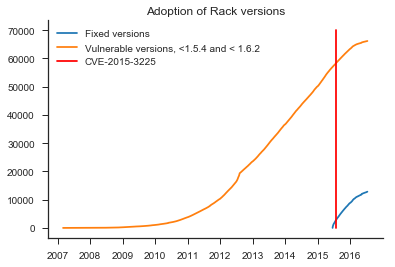

In [31]:
plt.figure()
plt.plot(a.index, a.values, "-", label="Fixed versions")
plt.plot(b.index, b.values, "-", label="Vulnerable versions, <1.5.4 and < 1.6.2")
plt.plot([pd.to_datetime(" 2015-07-26"), pd.to_datetime(" 2015-07-26")],[0, 70000], c="r", label = "CVE-2015-3225" )
plt.title("Adoption of Rack versions")
plt.legend()
sns.despine()


In [32]:
packages_using = stacked_ts[["project_name", "vulnerable_target", "release_ts"]].groupby(["project_name", "vulnerable_target"]).min().reset_index()
packages_using = packages_using.pivot( index="project_name", values="release_ts", columns="vulnerable_target")

## Packages using vulnerable version of Rack

In [33]:
packages_using[~pd.isnull(packages_using[1])].shape[0]

66193

## Packages using vulnerable version of Rack that upgraded to fixed version

In [34]:
packages_using[~pd.isnull(packages_using[1]) & (~pd.isnull(packages_using[0])) ].shape[0]

12608